In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import dependencies as deps

### Importing the images, matching and rectification.

In [43]:
# imgL = cv.imread('data/not_board/imageL3.png')
# imgR = cv.imread('data/not_board/imageR3.png')
imgL = cv.imread('data/stationary_not_board/imageL5.png')
imgR = cv.imread('data/stationary_not_board/imageR5.png')
#Pipeline to rectify images without using the precalculated fundamental matrix, 
#getting it by matching features of the images every time and calculating it.
good, pts1, pts2 = deps.find_matches(imgL, imgR)
imgL_rect, imgR_rect = deps.rectify_images(imgL, imgR, pts1, pts2)
#Get the rectified images using the precalculated fundamental matrix from the 
#chessboard method.
imgL_rect_pred, imgR_rect_pred = deps.rect_using_fmatrix(imgL, imgR)

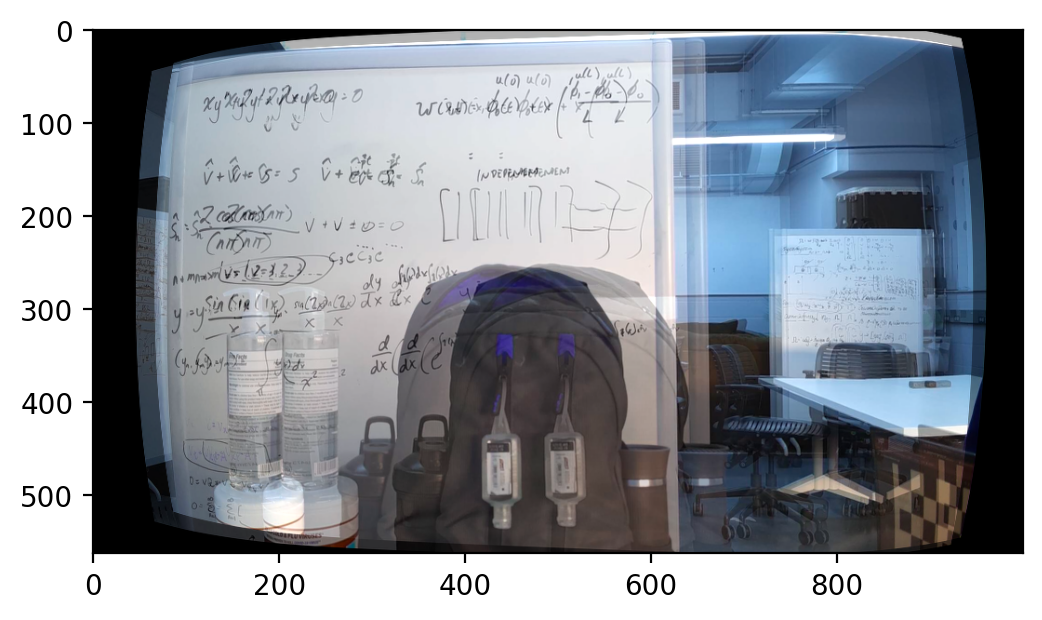

In [44]:
#check the vertical alignment just for fun.
dst = cv.addWeighted(imgL_rect_pred,0.5,imgR_rect_pred,0.7,0)
plt.figure(1234123, dpi = 200)
plt.imshow(dst)

In [38]:
# Optional: Drawing keypoints and matches.

# imgSift = cv.drawKeypoints(
#     imgL, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# draw_params = dict(matchColor=(0, 255, 0),
#                    singlePointColor=(255, 0, 0),
#                    matchesMask=matchesMask[300:500],
#                    #matchesMask=matchesMask,
#                    flags=cv.DrawMatchesFlags_DEFAULT)

# keypoint_matches = cv.drawMatchesKnn(
#     imgL, kp1, imgR, kp2, matches[300:500], None, **draw_params)
    #imgL, kp1, imgR, kp2, matches, None, **draw_params)

### Calculating Disparity

In [45]:
block_size = 9
min_disp = -144
max_disp = +144
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 10
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 200
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0

matcher = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=2 * 1 * block_size * block_size,
    P2=10 * 1 * block_size * block_size,
)
disparity = matcher.compute(imgL_rect, imgR_rect)
disparity_pred = matcher.compute(imgL_rect_pred, imgR_rect_pred)

filtered_left, filtered_right = deps.disp_filtering(imgL_rect, imgR_rect, matcher)
filtered_left_pred, filtered_right_pred = deps.disp_filtering(imgL_rect_pred, imgR_rect_pred, matcher, 16000, 2)

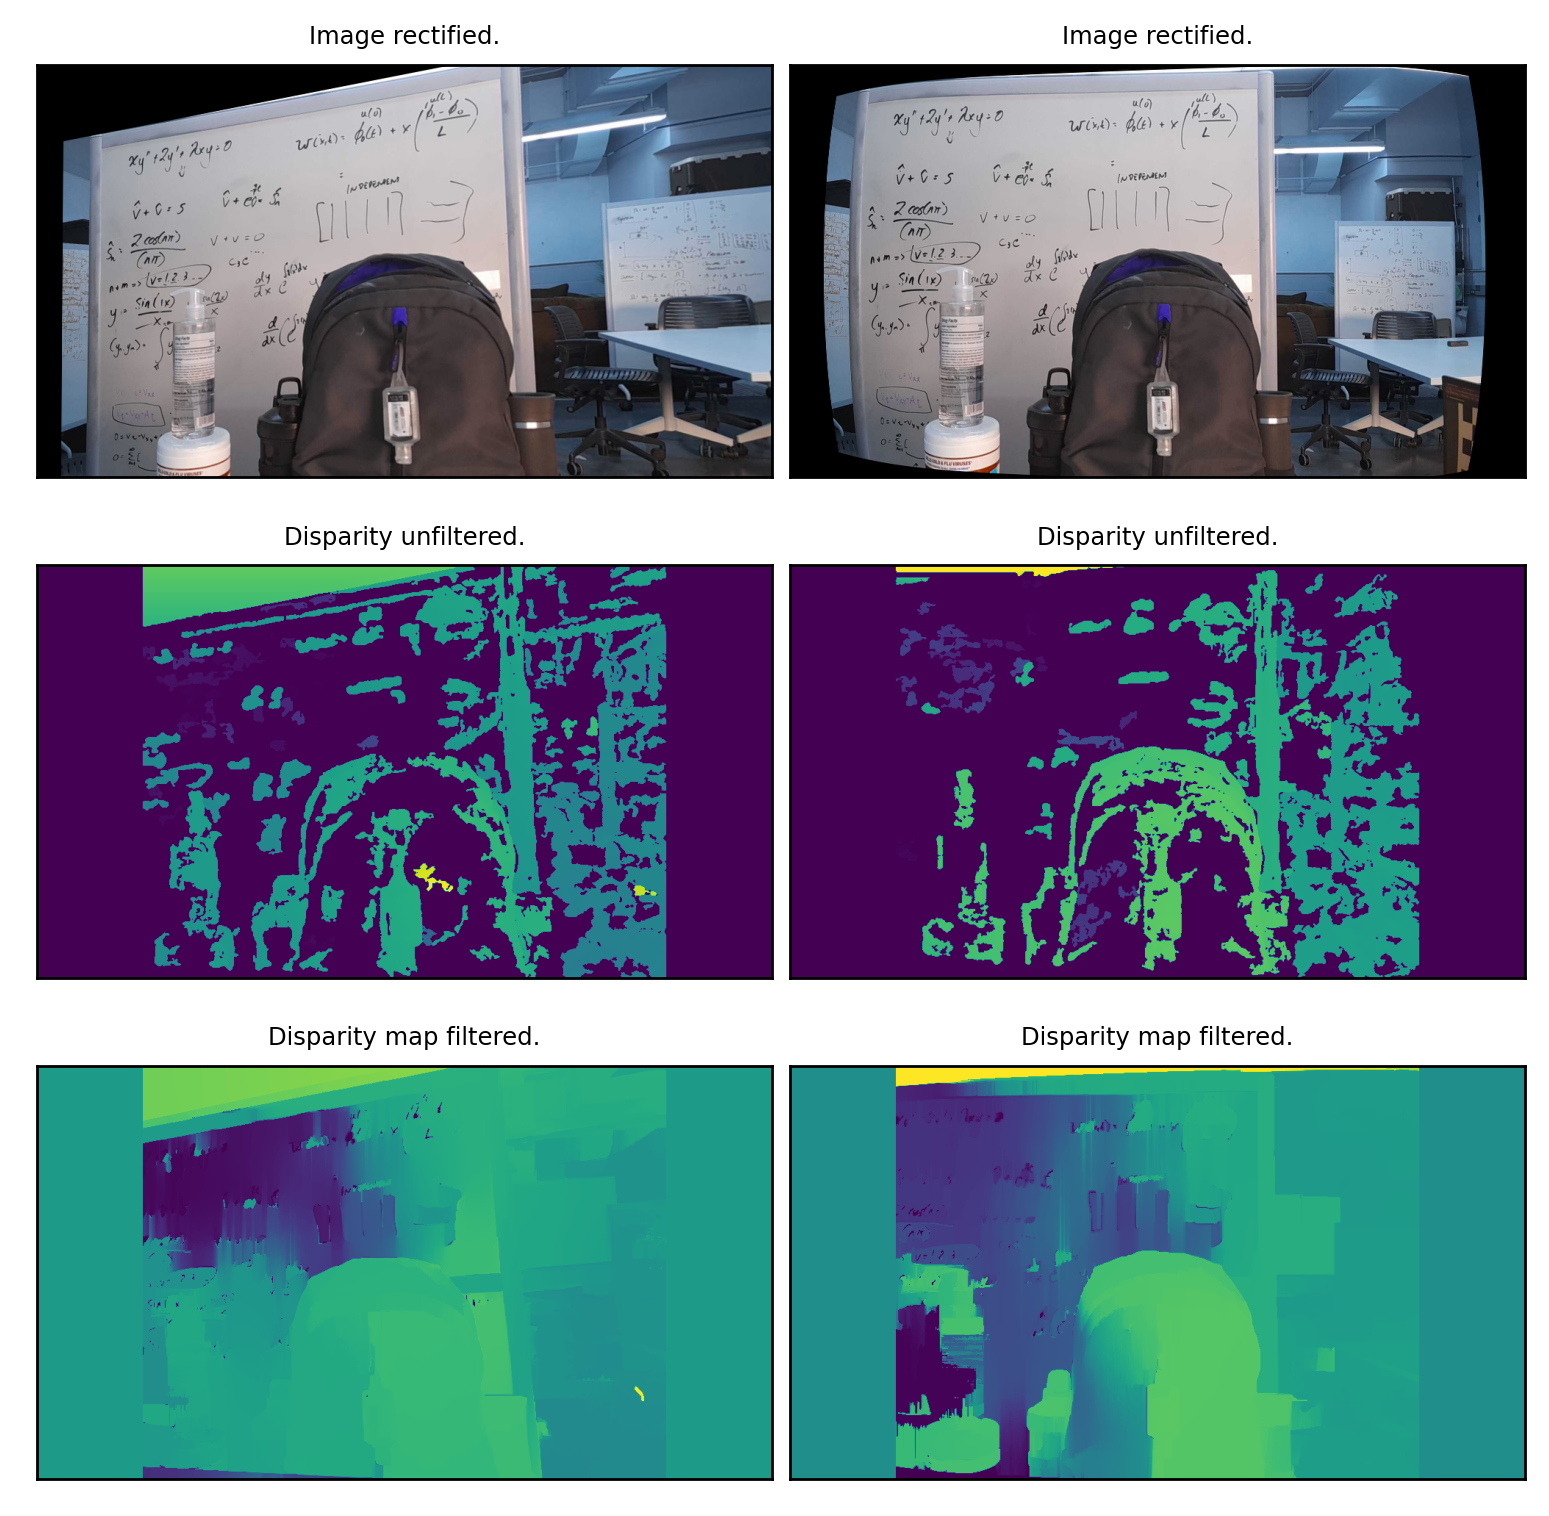

In [46]:
fig = plt.figure(4, figsize = (6,6), dpi = 250)
fig.patch.set_facecolor('w')

nrows = 3
ncols = 2

plt.subplot(nrows,ncols,1)
plt.title("Image rectified.", fontsize=7)
plt.imshow(imgL_rect)

plt.subplot(nrows,ncols,3)
plt.title("Disparity unfiltered.", fontsize=7)
plt.imshow(disparity)

plt.subplot(nrows,ncols,5)
plt.title("Disparity map filtered.", fontsize=7)
plt.imshow(deps.clamp(filtered_right))

plt.subplot(nrows,ncols,2)
plt.title("Image rectified.", fontsize=7)
plt.imshow(imgL_rect_pred)

plt.subplot(nrows,ncols,4)
plt.title("Disparity unfiltered.", fontsize=7)
plt.imshow(disparity_pred)

plt.subplot(nrows,ncols,6)
plt.title("Disparity map filtered.", fontsize=7)
plt.imshow(deps.clamp(filtered_left_pred))

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout(pad = 0)
plt.subplots_adjust(wspace=0.025, hspace = 0.05)
# fig = plt.gcf()
# fig.suptitle("Title centered above all subplots", fontsize=14)